In [1]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

import xgboost as xgb
import lightgbm as lgb

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("../input/tabular-playground-series-aug-2022/train.csv", index_col='id')
test = pd.read_csv("../input/tabular-playground-series-aug-2022/test.csv", index_col='id')

In [3]:
labels = train['failure']
X_train = train.drop(columns=['failure'], axis=1)

In [4]:
train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


First observations:
* attribute_0, attibute_1 -> categorical features?
* product_code -> are there same product codes in train and test datasets?

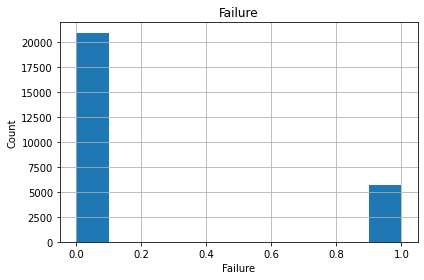

In [5]:
plt.figure(figsize=(6,4))

train['failure'].hist()

plt.xlabel('Failure')
plt.ylabel('Count')
plt.title('Failure')
plt.tight_layout()
plt.show()

In [6]:
failure_group = train.groupby('failure').count().min(axis=1)

not_failed = failure_group[0]
failed = failure_group[1]
total = not_failed + failed

failures_frac = failed / total

In [7]:
print(not_failed / total * 100)
print(failed / total * 100)

78.79436712509265
21.205632874907355


* Strong class imbalance -> consider over/undersampling ()
* undersampling may cause shortage of data - we will throw away 60% of data

In [8]:
columns = list(train.columns)

In [9]:
train.isnull().sum(axis=0)

product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

A bunch of null data. What should we do about it?

In [10]:
# https://stackoverflow.com/questions/48568661/pandas-number-of-rows-with-missing-data
train.isnull().any(axis=1).sum()

14387

Insight: Should not drop that rows - we would lose a lot of data

### Encode categorical featues

In [11]:
display(train)

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,E,158.95,material_7,material_6,6,9,6,16,4,16.301,...,NaN,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131,0
26566,E,146.02,material_7,material_6,6,9,10,12,8,17.543,...,11.242,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924,0
26567,E,115.62,material_7,material_6,6,9,1,10,1,15.670,...,11.407,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364,0


In [12]:
# probably should use OneHotEncoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train['product_code'] = label_encoder.fit_transform(train['product_code'])
train['attribute_0'] = label_encoder.fit_transform(train['attribute_0'])
train['attribute_1'] = label_encoder.fit_transform(train['attribute_1'])

In [13]:
train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,0,80.10,1,2,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,0,84.89,1,2,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,0,82.43,1,2,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,0,101.07,1,2,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,0,188.06,1,2,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [14]:
for column in columns:
    print(train[column].describe(), end='\n\n')

count    26570.000000
mean         2.013097
std          1.400728
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: product_code, dtype: float64

count    26320.000000
mean       127.826233
std         39.030020
min         33.160000
25%         99.987500
50%        122.390000
75%        149.152500
max        385.860000
Name: loading, dtype: float64

count    26570.000000
mean         0.802409
std          0.398190
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: attribute_0, dtype: float64

count    26570.000000
mean         1.018931
std          0.893633
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: attribute_1, dtype: float64

count    26570.000000
mean         6.754046
std          1.471852
min          5.000000
25%          6.000000
50%          6.000000
75%          8.000000
max  

In [15]:
for column in columns:
    print(f"Number of unique values in {column}: {train[column].nunique()}")

Number of unique values in product_code: 5
Number of unique values in loading: 11950
Number of unique values in attribute_0: 2
Number of unique values in attribute_1: 3
Number of unique values in attribute_2: 4
Number of unique values in attribute_3: 4
Number of unique values in measurement_0: 29
Number of unique values in measurement_1: 30
Number of unique values in measurement_2: 25
Number of unique values in measurement_3: 4721
Number of unique values in measurement_4: 4692
Number of unique values in measurement_5: 4671
Number of unique values in measurement_6: 4704
Number of unique values in measurement_7: 4734
Number of unique values in measurement_8: 4713
Number of unique values in measurement_9: 4708
Number of unique values in measurement_10: 6177
Number of unique values in measurement_11: 6526
Number of unique values in measurement_12: 6392
Number of unique values in measurement_13: 5271
Number of unique values in measurement_14: 6389
Number of unique values in measurement_15: 

In [16]:
for column in ['product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']:
    print(f"Unique values for {column}: {train[column].unique()}")

Unique values for product_code: [0 1 2 3 4]
Unique values for attribute_0: [1 0]
Unique values for attribute_1: [2 0 1]
Unique values for attribute_2: [9 8 5 6]
Unique values for attribute_3: [5 8 6 9]


### Histograms

In [17]:
# 25
feature_columns = columns[:]
feature_columns.remove('failure')

In [18]:
print(feature_columns)
print(len(feature_columns))

['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']
24


In [19]:
display(labels)

id
0        0
1        0
2        0
3        0
4        0
        ..
26565    0
26566    0
26567    0
26568    0
26569    0
Name: failure, Length: 26570, dtype: int64

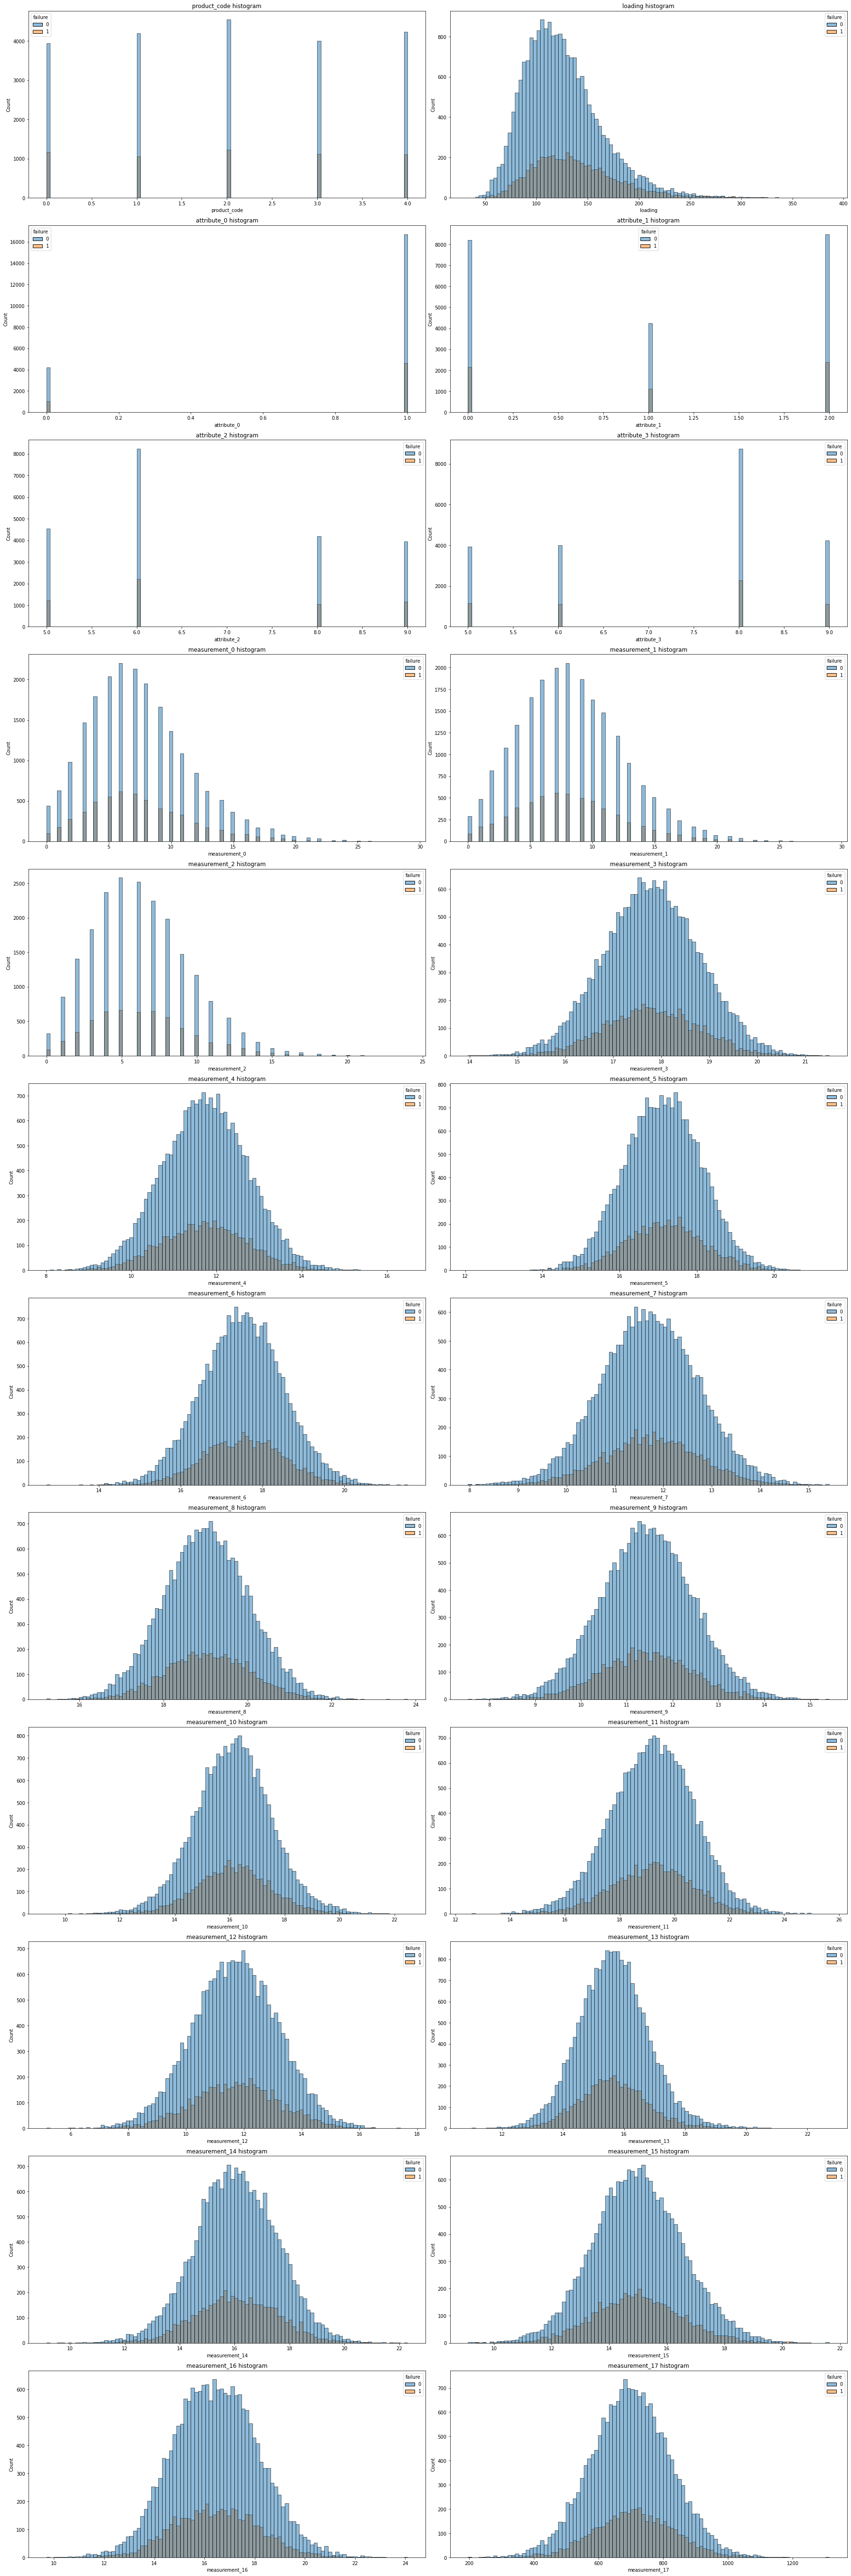

In [20]:
figure = plt.figure(figsize=(25,100))
for i, feature in enumerate(feature_columns):
    plt.subplot(16, 2, i+1)
    sns.histplot(data=train, x=feature, bins=100, hue='failure')
    plt.title(f'{feature} histogram')
    
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.show()

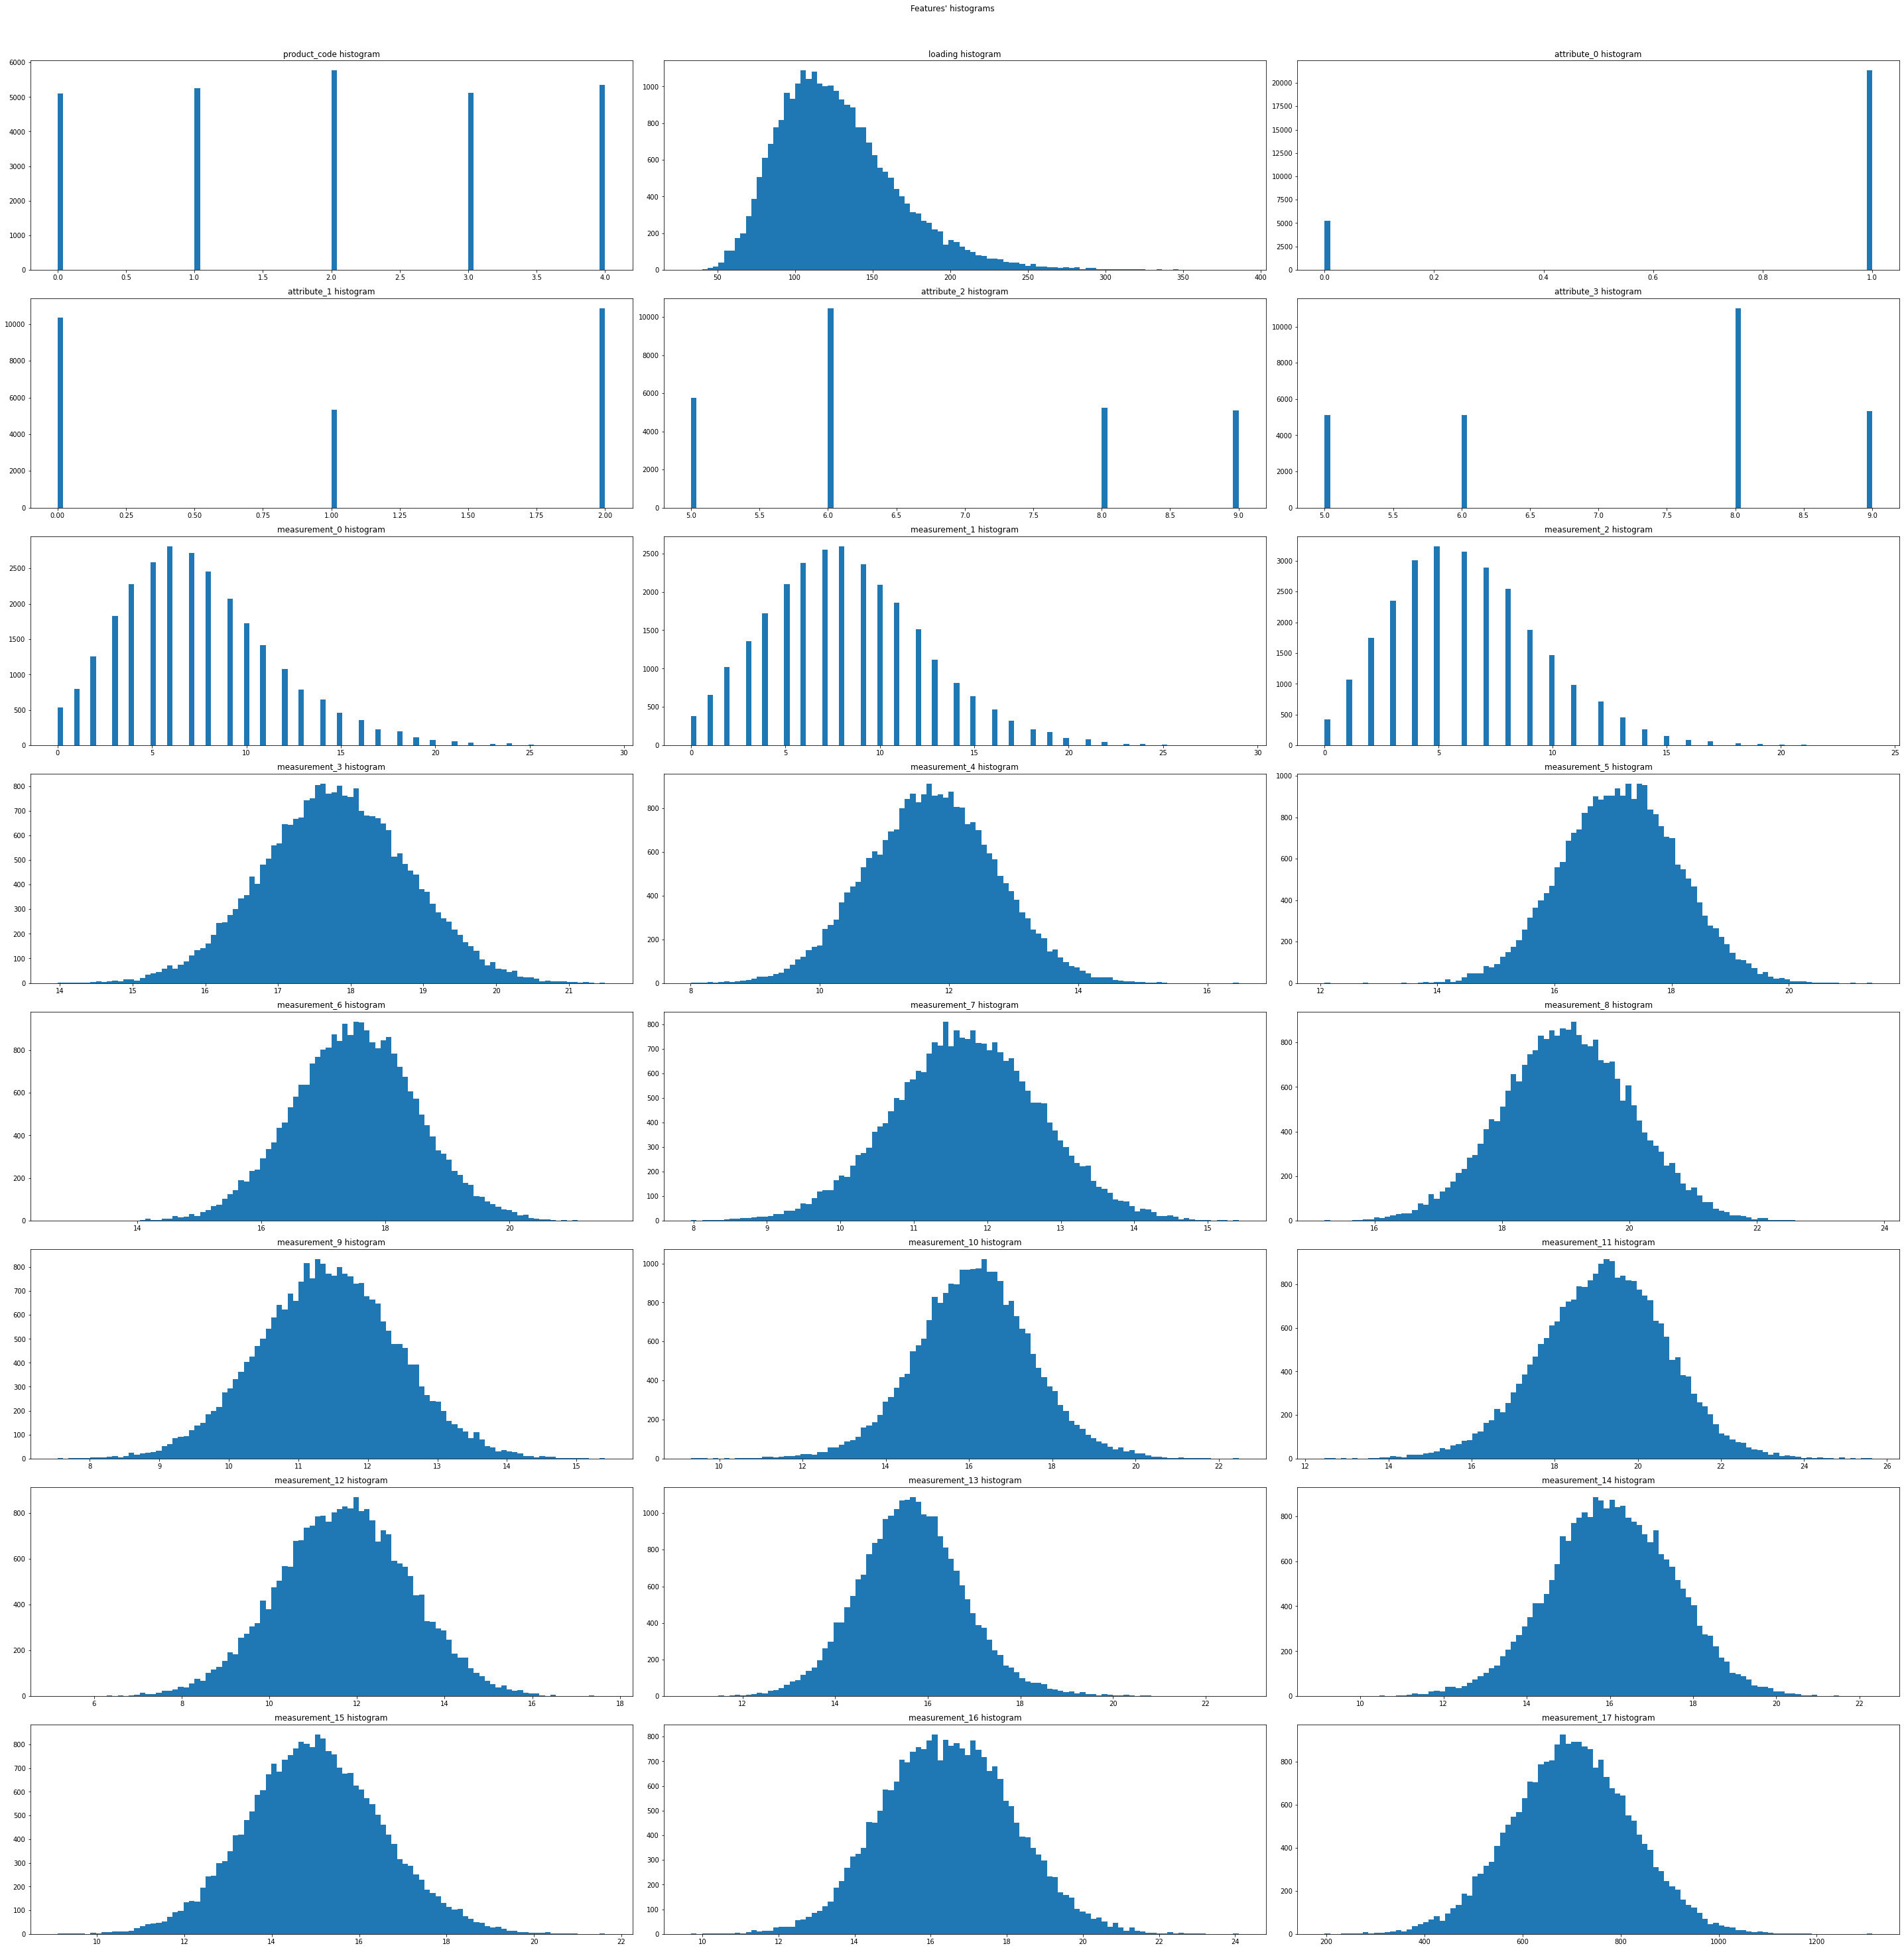

In [21]:
figure = plt.figure(figsize=(40,40))
for i, feature in enumerate(feature_columns):
    plt.subplot(8, 3, i+1)
    plt.hist(train[feature], bins=100)
    plt.title(f'{feature} histogram')
    
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle("Features' histograms", y=1.02)
plt.show()

Insight:
* Data does not seem to have many outsiders
* Measurment_3 to _17 seem to have normal distribution
* Measurment_0 to _2 seem to have poisson distribution
* loading seems to have chi^2 distribution
* a bunch of discreet featues

### Corrleations between features

In [22]:
corr_matrix = train.corr(method='pearson')

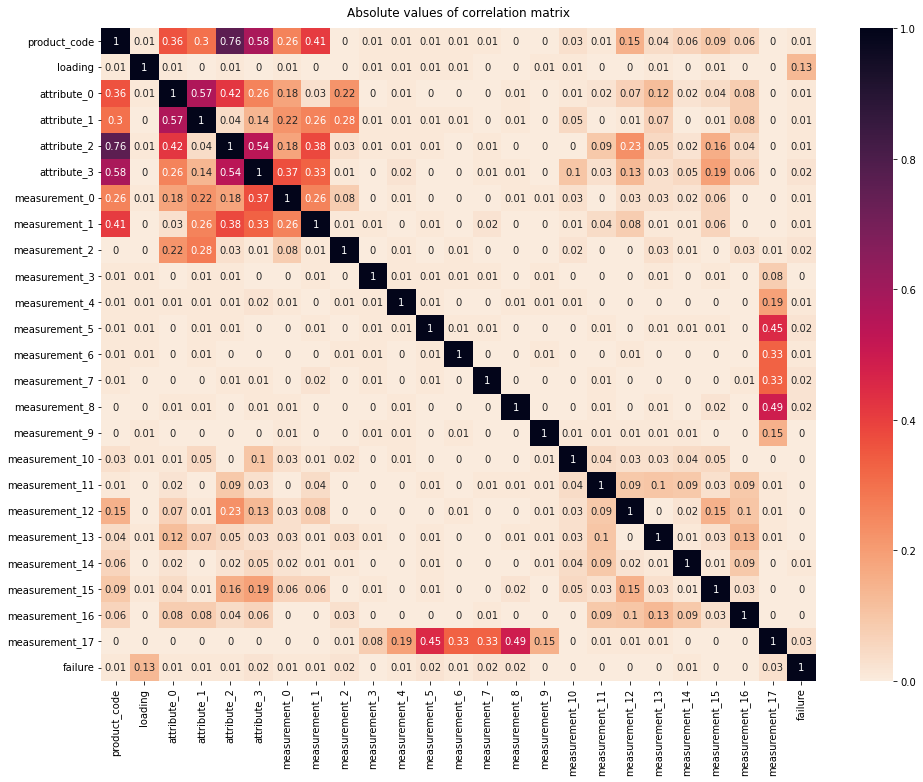

In [23]:
# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
plt.figure(figsize=(16, 12))

heatmap = sns.heatmap(np.abs(corr_matrix.round(2)), vmin=0, vmax=1, annot=True, cmap='rocket_r')
heatmap.set_title('Absolute values of correlation matrix', pad=12);


In [24]:
for feature in feature_columns:
    try:
        print(feature)
        display(corr_matrix[abs(corr_matrix[feature]) > 0.1][feature])
        print("----------------------------------")
    except:
        pass

product_code


product_code      1.000000
attribute_0       0.358915
attribute_1      -0.302747
attribute_2      -0.755114
attribute_3       0.577926
measurement_0    -0.258819
measurement_1     0.409682
measurement_12   -0.153309
Name: product_code, dtype: float64

----------------------------------
loading


loading    1.000000
failure    0.129089
Name: loading, dtype: float64

----------------------------------
attribute_0


product_code      0.358915
attribute_0       1.000000
attribute_1       0.565822
attribute_2      -0.420080
attribute_3      -0.258784
measurement_0     0.178827
measurement_2    -0.224830
measurement_13   -0.115123
Name: attribute_0, dtype: float64

----------------------------------
attribute_1


product_code    -0.302747
attribute_0      0.565822
attribute_1      1.000000
attribute_3     -0.135736
measurement_0    0.215974
measurement_1   -0.264908
measurement_2   -0.283106
Name: attribute_1, dtype: float64

----------------------------------
attribute_2


product_code     -0.755114
attribute_0      -0.420080
attribute_2       1.000000
attribute_3      -0.538697
measurement_0     0.175387
measurement_1    -0.377971
measurement_12    0.226756
measurement_15   -0.161242
Name: attribute_2, dtype: float64

----------------------------------
attribute_3


product_code      0.577926
attribute_0      -0.258784
attribute_1      -0.135736
attribute_2      -0.538697
attribute_3       1.000000
measurement_0    -0.370232
measurement_1     0.329233
measurement_10   -0.100845
measurement_12   -0.132060
measurement_15    0.187519
Name: attribute_3, dtype: float64

----------------------------------
measurement_0


product_code    -0.258819
attribute_0      0.178827
attribute_1      0.215974
attribute_2      0.175387
attribute_3     -0.370232
measurement_0    1.000000
measurement_1   -0.255255
Name: measurement_0, dtype: float64

----------------------------------
measurement_1


product_code     0.409682
attribute_1     -0.264908
attribute_2     -0.377971
attribute_3      0.329233
measurement_0   -0.255255
measurement_1    1.000000
Name: measurement_1, dtype: float64

----------------------------------
measurement_2


attribute_0     -0.224830
attribute_1     -0.283106
measurement_2    1.000000
Name: measurement_2, dtype: float64

----------------------------------
measurement_3


measurement_3    1.0
Name: measurement_3, dtype: float64

----------------------------------
measurement_4


measurement_4     1.000000
measurement_17    0.193045
Name: measurement_4, dtype: float64

----------------------------------
measurement_5


measurement_5     1.000000
measurement_17    0.450024
Name: measurement_5, dtype: float64

----------------------------------
measurement_6


measurement_6     1.000000
measurement_17    0.328136
Name: measurement_6, dtype: float64

----------------------------------
measurement_7


measurement_7     1.000000
measurement_17    0.330328
Name: measurement_7, dtype: float64

----------------------------------
measurement_8


measurement_8     1.000000
measurement_17    0.492839
Name: measurement_8, dtype: float64

----------------------------------
measurement_9


measurement_9     1.000000
measurement_17    0.145465
Name: measurement_9, dtype: float64

----------------------------------
measurement_10


attribute_3      -0.100845
measurement_10    1.000000
Name: measurement_10, dtype: float64

----------------------------------
measurement_11


measurement_11    1.0
Name: measurement_11, dtype: float64

----------------------------------
measurement_12


product_code     -0.153309
attribute_2       0.226756
attribute_3      -0.132060
measurement_12    1.000000
measurement_15   -0.152583
Name: measurement_12, dtype: float64

----------------------------------
measurement_13


attribute_0      -0.115123
measurement_13    1.000000
measurement_16    0.131495
Name: measurement_13, dtype: float64

----------------------------------
measurement_14


measurement_14    1.0
Name: measurement_14, dtype: float64

----------------------------------
measurement_15


attribute_2      -0.161242
attribute_3       0.187519
measurement_12   -0.152583
measurement_15    1.000000
Name: measurement_15, dtype: float64

----------------------------------
measurement_16


measurement_13    0.131495
measurement_16    1.000000
Name: measurement_16, dtype: float64

----------------------------------
measurement_17


measurement_4     0.193045
measurement_5     0.450024
measurement_6     0.328136
measurement_7     0.330328
measurement_8     0.492839
measurement_9     0.145465
measurement_17    1.000000
Name: measurement_17, dtype: float64

----------------------------------


There are some correlations between features, but only loading is correlated with failure

### How each feature is useful

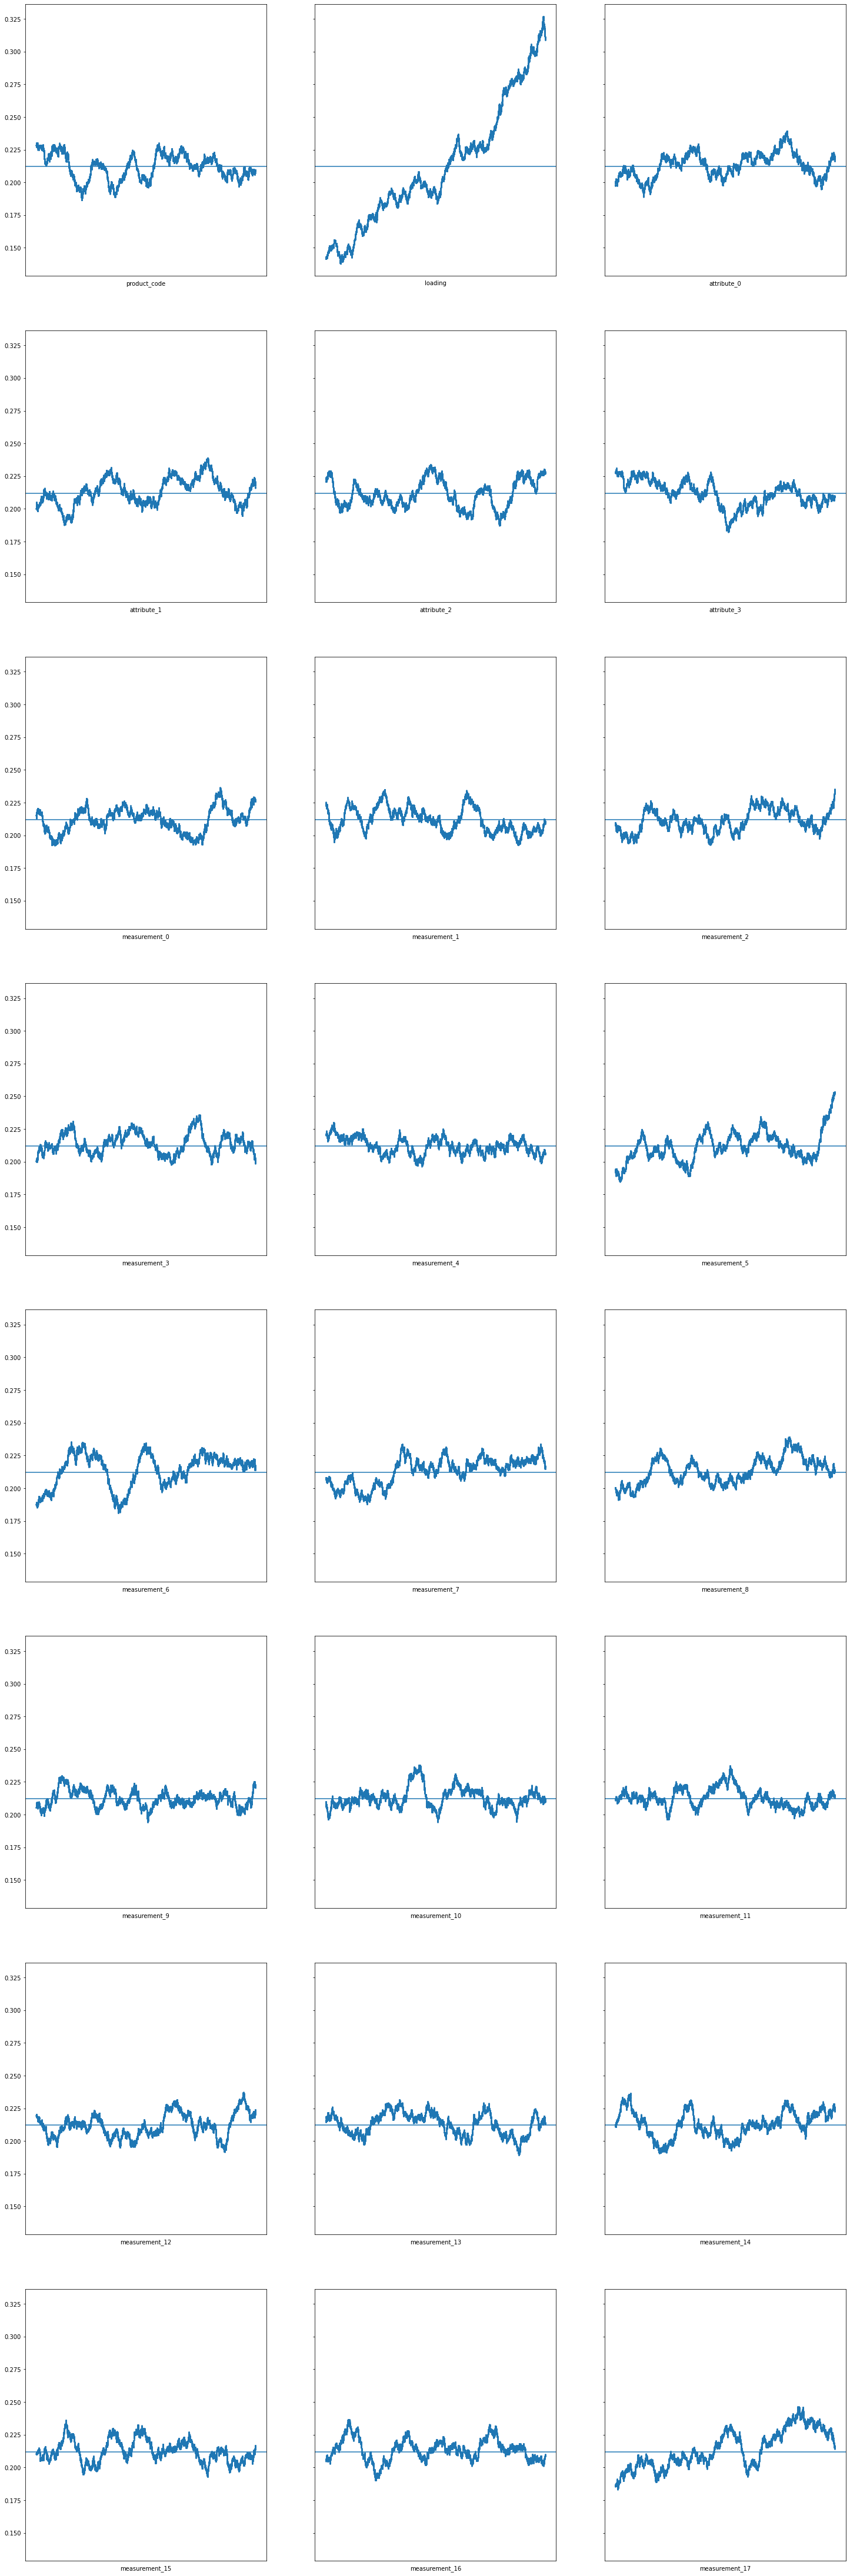

In [25]:
# inspired by https://www.kaggle.com/code/ambrosm/tpsapr22-best-model-without-nn/notebook

plt.subplots(8, 3, sharey=True, sharex=True, figsize=(25, 80))
rolling_mean = 2000

def plot_dependance(feature, plot_no, rolling_mean=1000):
    temp = pd.DataFrame({feature: train[feature].values, 'failure': train.failure.values})
    temp = temp.sort_values(feature)
    temp.reset_index(inplace=True)

    plt.subplot(8, 3, plot_no)
    plt.scatter(temp.index, temp.failure.rolling(rolling_mean).mean(), s=2)
    plt.xlabel(feature)
    plt.xticks([])
    plt.axhline(y=failures_frac)

for i, feature in enumerate(feature_columns):
    plot_dependance(feature, i+1, rolling_mean)

plt.show()

* Loading should have the most significant influence on the failure

### Rolling correlation
https://www.kaggle.com/code/hasanbasriakcay/tpsaug22-insightful-eda-new-lib-featimp

In [26]:
import gc
def reg_rolling_correlation_plot(data, features, target, ncols=3, rolling_num=1000):
    nrows = int(len(features) / ncols) + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, round(nrows*16/ncols)))
    for ax,feature in zip(axes.ravel()[:len(features)],features):
        temp = data.sort_values(feature)
        temp.reset_index(inplace=True)
        ax.scatter(temp.index, temp[target].rolling(rolling_num).mean(), s=1, alpha=0.5)
        ax.set_xlabel(feature)
        del temp
        gc.collect()
    for ax in axes.ravel()[len(features):]:
        ax.set_visible(False)
    fig.tight_layout()
    plt.show()

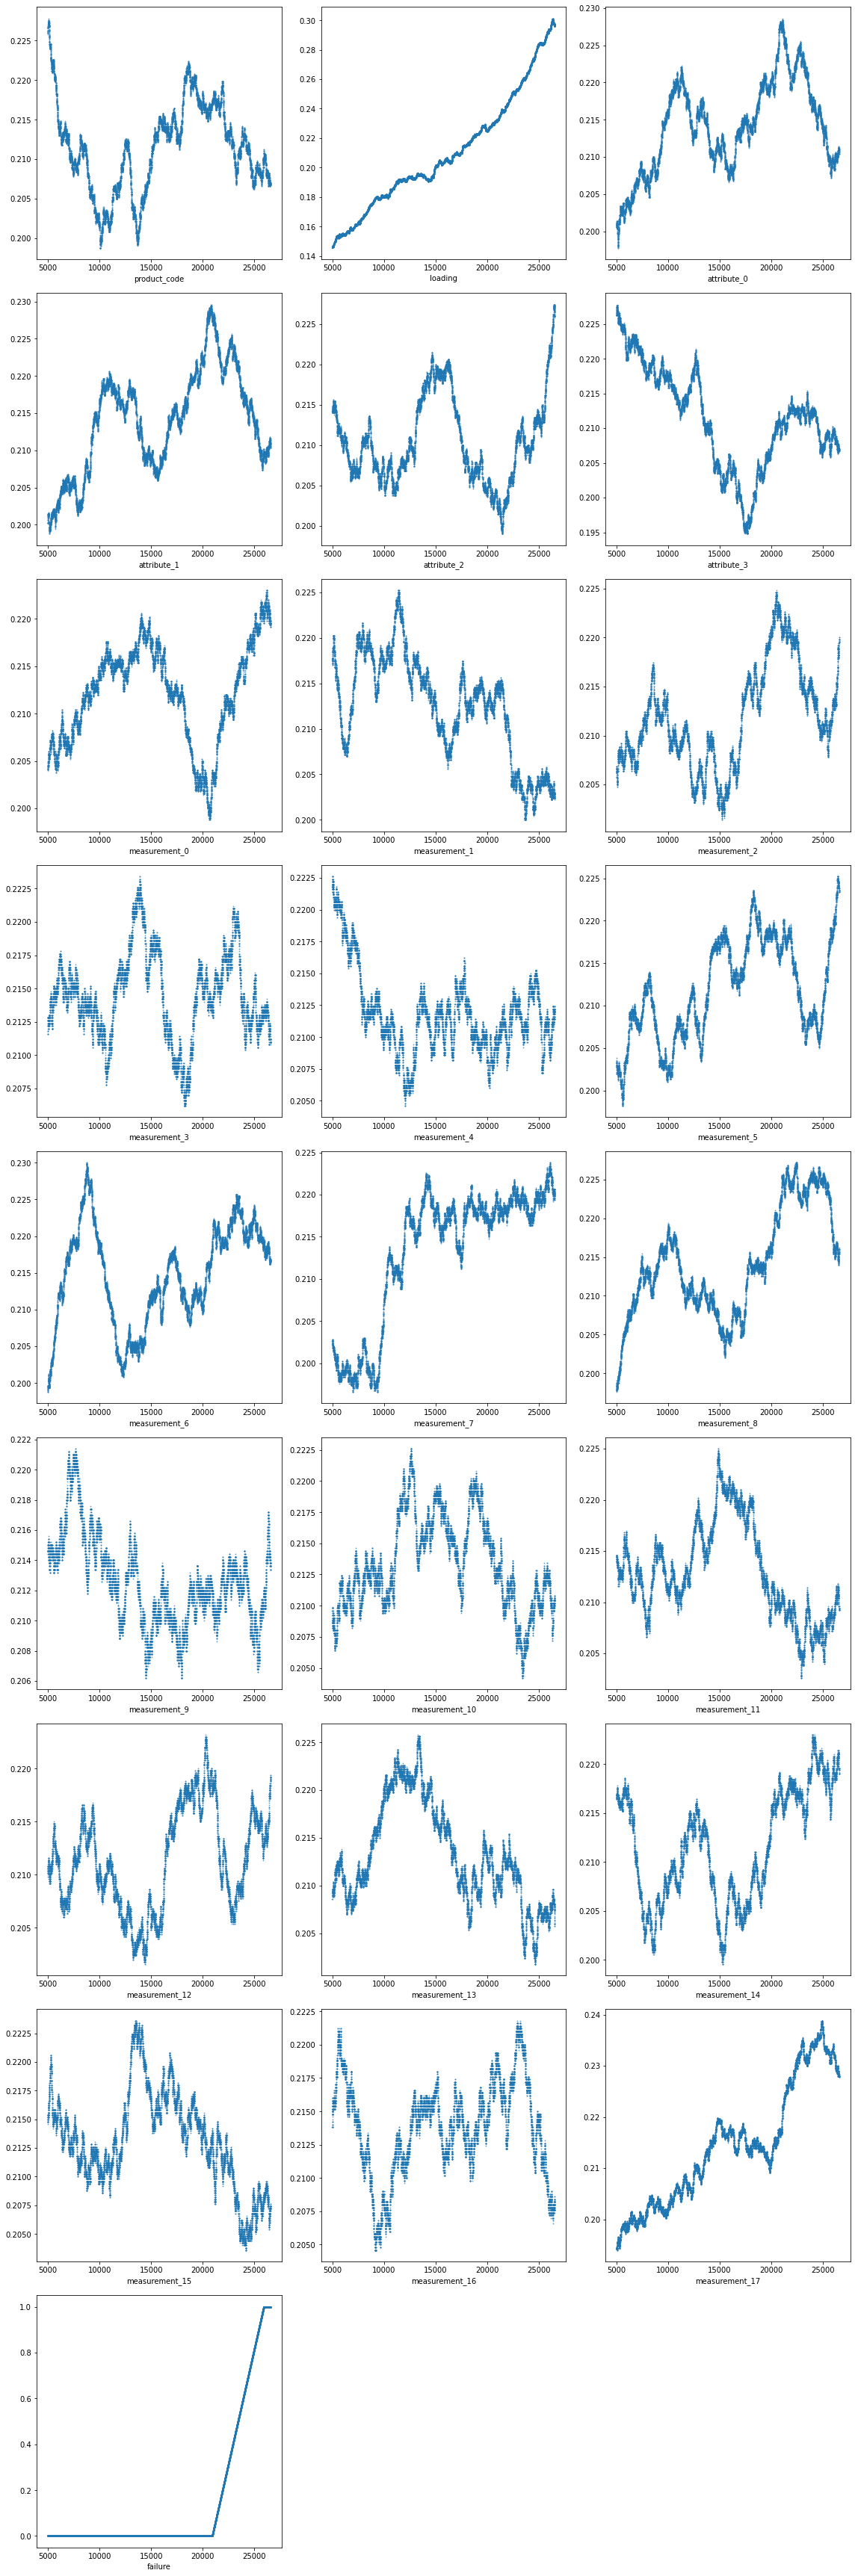

In [27]:
reg_rolling_correlation_plot(train, columns, "failure", ncols=3, rolling_num=5000)

### Comparison to test dataset

In [28]:
train_raw = pd.read_csv("../input/tabular-playground-series-aug-2022/train.csv", index_col='id')
test_raw = pd.read_csv("../input/tabular-playground-series-aug-2022/test.csv", index_col='id')

In [29]:
train_raw.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [30]:
print(train_raw['product_code'].unique())
print(test_raw['product_code'].unique())

['A' 'B' 'C' 'D' 'E']
['F' 'G' 'H' 'I']


Insight: We should not use product code as a feature as it does not tell gives any information when it comes to test dataset.
TODO: investigate if number of rows in each product code has an influence on failure

A    85
D    85
B    87
E    89
C    96
Name: sequence count per training subject, dtype: int64
H    83
G    85
I    87
F    90
Name: sequence count per test subject, dtype: int64


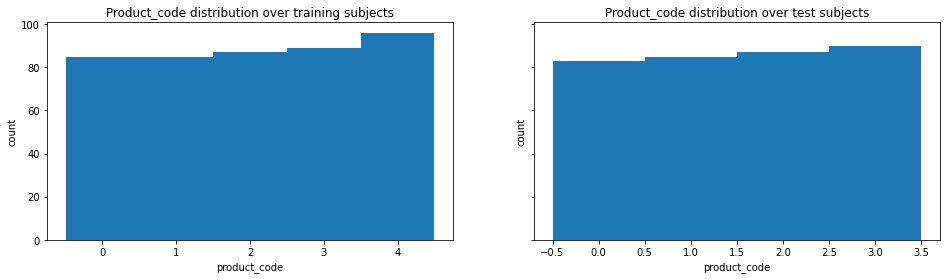

In [31]:
# https://www.kaggle.com/code/ambrosm/tpsapr22-eda-which-makes-sense
plt.subplots(1, 2, sharey=True, figsize=(16, 4))
def plot_product_code_distribution(df, title):
    temp = df['product_code'].value_counts().sort_values() // 60
    plt.bar(range(len(temp)), temp, width=1)
    plt.xlabel('product_code')
    plt.ylabel('count')
    plt.title(f'Product_code distribution over {title} subjects')
    print(temp.sort_values().rename(f'sequence count per {title} subject'))

plt.subplot(1, 2, 1)
plot_product_code_distribution(train_raw, 'training')
plt.subplot(1, 2, 2)
plot_product_code_distribution(test_raw, 'test')
plt.show()

Products seems to be uniformly distributed

In [32]:
# https://www.kaggle.com/code/ambrosm/tpsapr22-eda-which-makes-sense
# temp = train_raw
# temp = temp.groupby('product_code')\
#            .agg({'failure': 'mean', 'product_code': 'count'})\
#            .rename(columns={'failure': 'probability', 'product_code': 'sequence_count'})
# temp1 = temp[temp.sequence_count >= 25].probability.rename('Probability of state==1')
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
# plt.hist(temp1, bins=20)
# plt.ylabel('Subject count')
# plt.xlabel('Probability for state==1')
# plt.title('Histogram of state probabilities per subject')

# plt.subplot(1, 2, 2)
# plt.scatter(temp.sequence_count, temp.probability)
# plt.xlabel('sequence count')
# plt.ylabel('probability')
# plt.title('Probability depends on sequence count')
# plt.show()

# print()
# print(f"The standard deviation of {temp[temp.sequence_count >= 25].probability.std():.2f} is much higher than 0.1.")
# print()
# print('Subjects which are always in state 0:', (temp.probability == 0).sum())

In [33]:
print(train_raw['attribute_0'].unique())
print(test_raw['attribute_0'].unique())

['material_7' 'material_5']
['material_5' 'material_7']


In [34]:
print(train_raw['attribute_1'].unique())
print(test_raw['attribute_1'].unique())

['material_8' 'material_5' 'material_6']
['material_6' 'material_7' 'material_5']


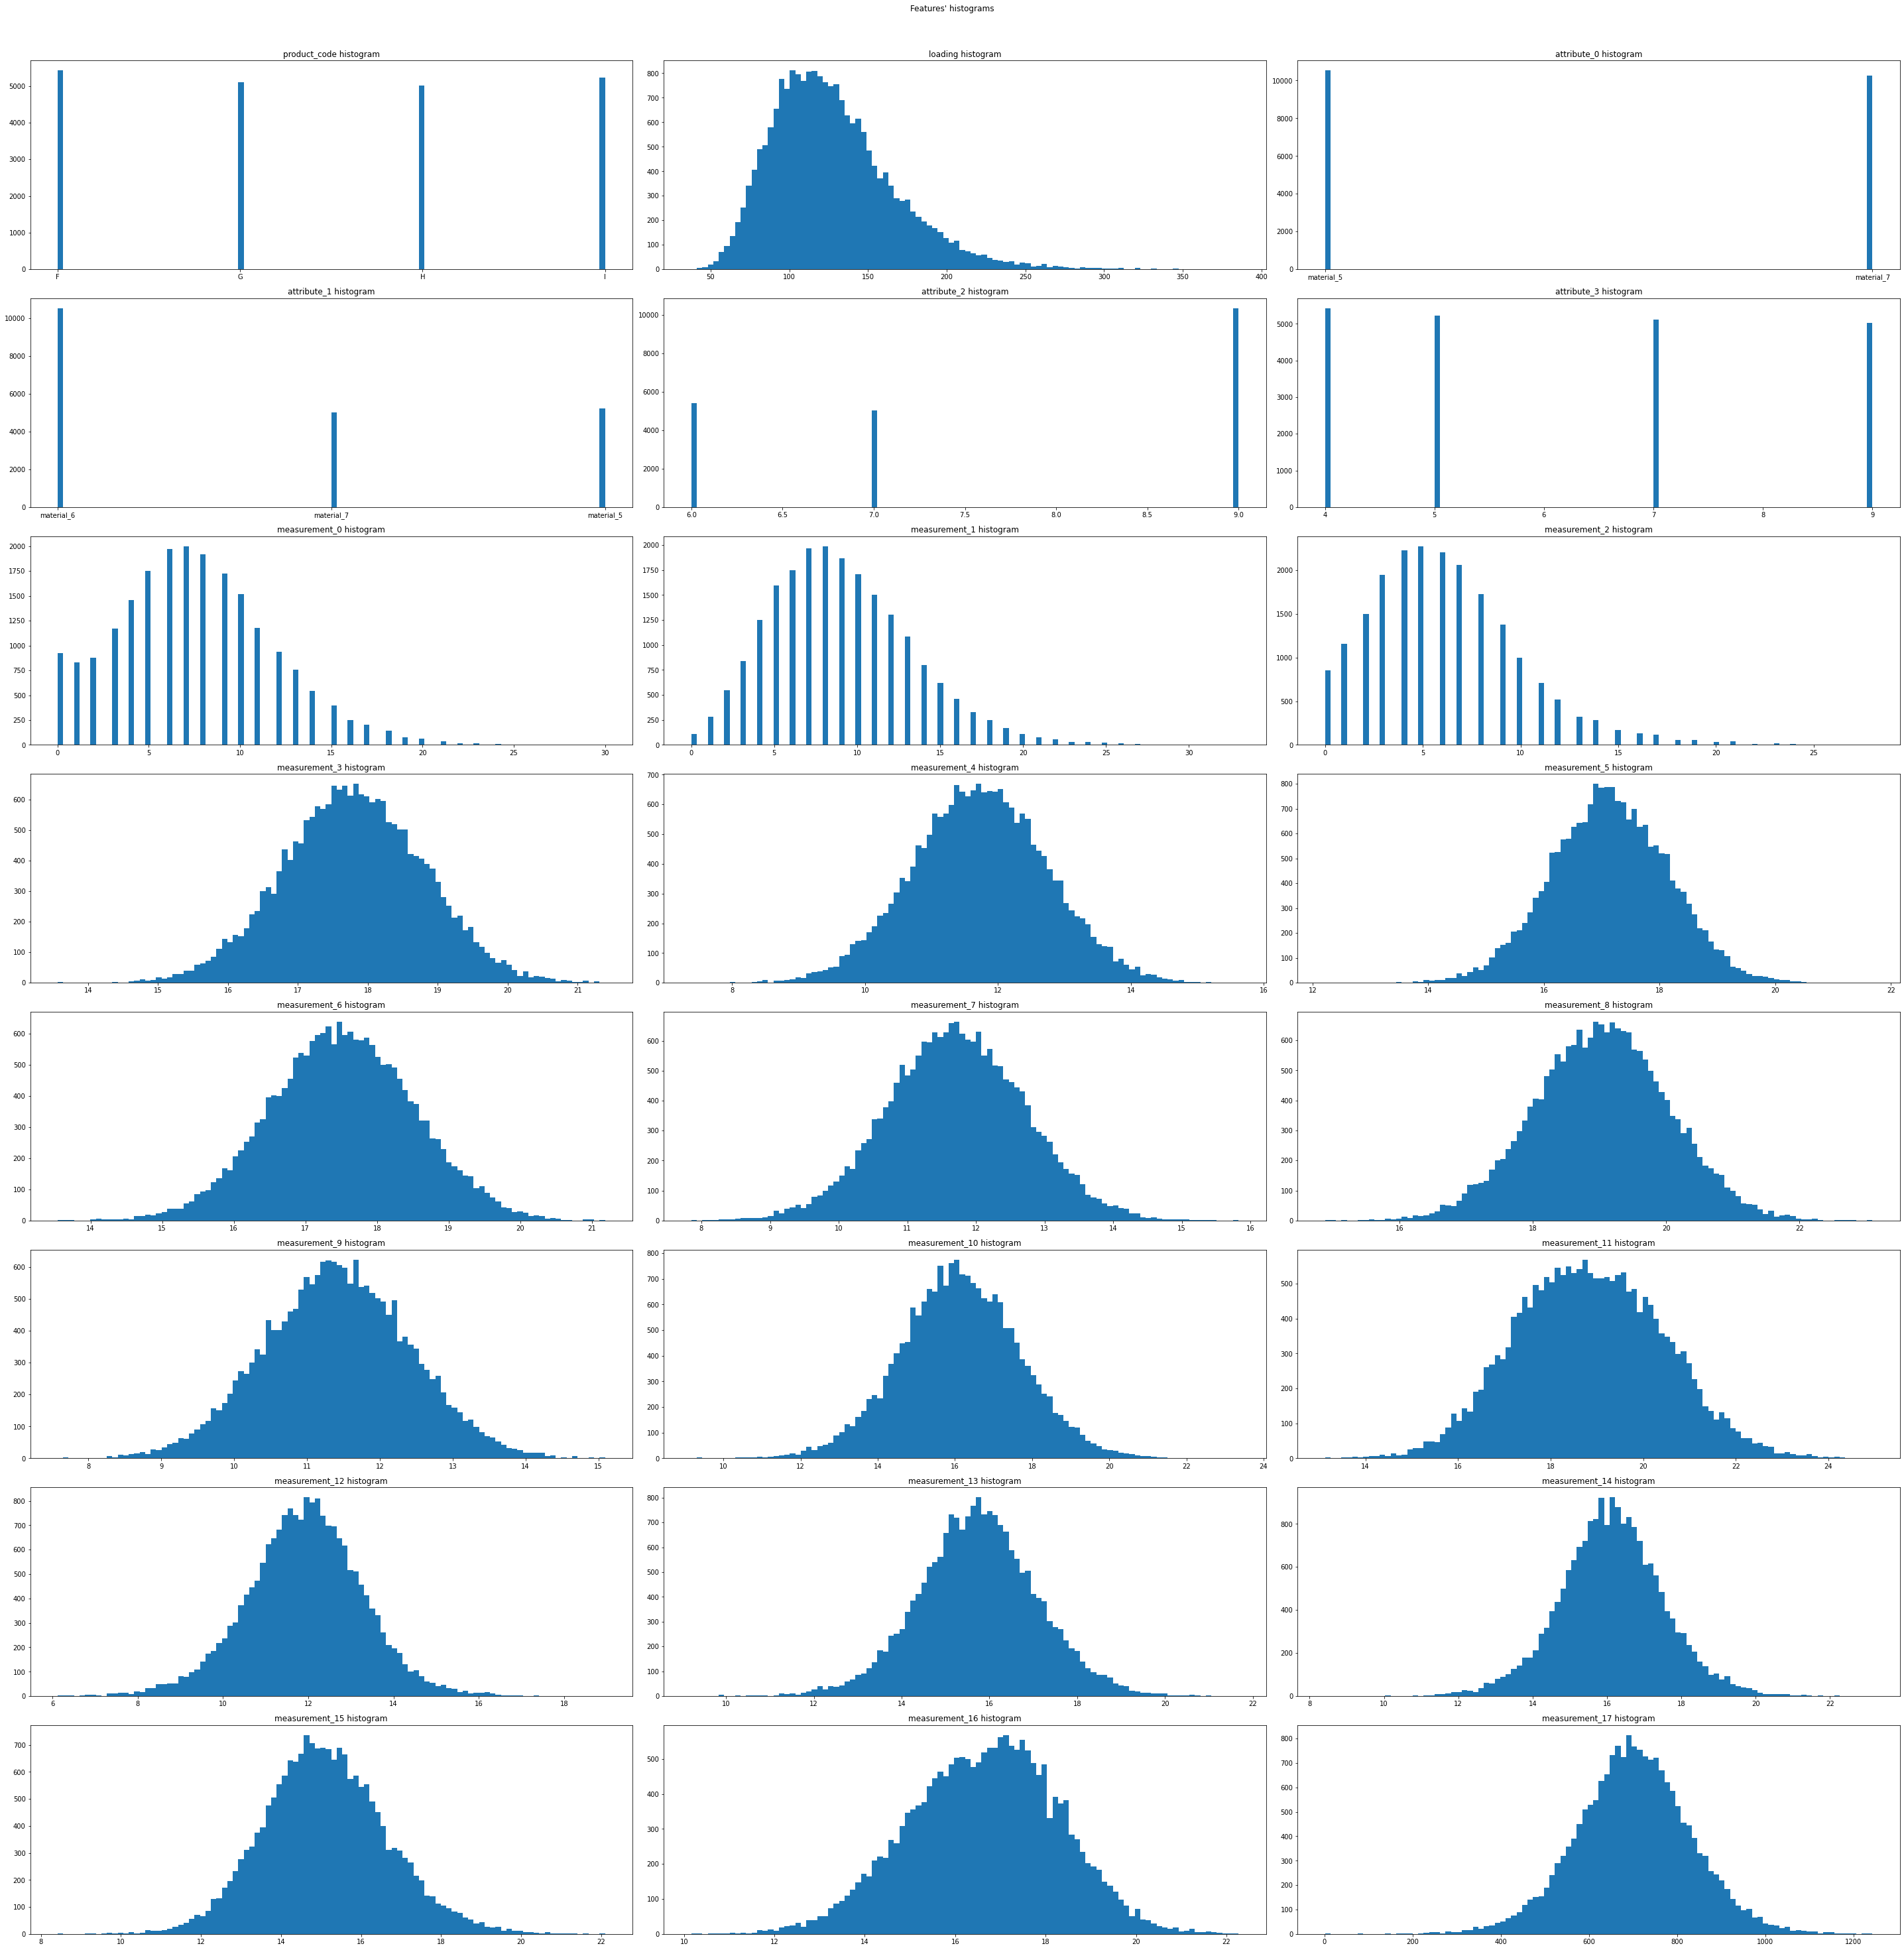

In [35]:
figure = plt.figure(figsize=(40,40))
for i, feature in enumerate(test_raw.columns):
    plt.subplot(8, 3, i+1)
    plt.hist(test_raw[feature], bins=100)
    plt.title(f'{feature} histogram')
    
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle("Features' histograms", y=1.02)
plt.show()

Test dataset seems to have similiar distribution to train dataset apart from attribute_2 and _3